# ConvLSTM model

Import libraries and modules.

In [1]:
%cd ..
%cd ..
# move to the root directory of the git

/workspace/FLOOD_group2/models
/workspace/FLOOD_group2


In [2]:
import importlib
import torch
import copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch.nn as nn

# Enable interactive widgets in Jupyter Notebook
%matplotlib widget

# import torch.nn.functional as F

from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import make_axes_locatable

from models.ConvLSTM_model.ConvLSTM_pytorch.convlstm import ConvLSTM
from pre_processing.encode_decode_csv import decode_from_csv
from pre_processing.normalization import * 
from post_processing.cool_animation import plot_animation

In [3]:
# importlib.reload(convlstm)

Check if GPU is available.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


The following lines create variables to more easily specify what we use the model for (i.e., train and validate, test with dataset 1 and so on) in the following functions.

In [5]:
train_val = 'train_val'
test1 = 'test1'
test2 = 'test2'
test3 = 'test3'

Load data from decoder.

**Please note**: 
\
inputs and targets in <code>train_val</code> are stored not in the original manner. 

index 0 = 1, index 1 = 10, index 11 = 2, index 12 = 20 etc.

In [6]:
# training and validation dataset
train_dataset = decode_from_csv(train_val)

Restored inputs Shape: torch.Size([80, 1, 4, 64, 64])
Restored targets Shape: torch.Size([80, 48, 2, 64, 64])


In [7]:
# first position is the samples, second decides between inputs or targets, notice new shape of inputs
train_dataset[0][0].shape

torch.Size([1, 4, 64, 64])

In [8]:
# test dataset 1
test_dataset1 = decode_from_csv(test1)

Restored inputs Shape: torch.Size([20, 1, 4, 64, 64])
Restored targets Shape: torch.Size([20, 48, 2, 64, 64])


In [9]:
# test dataset 2
test_dataset2 = decode_from_csv(test2)

Restored inputs Shape: torch.Size([21, 1, 4, 64, 64])
Restored targets Shape: torch.Size([21, 48, 2, 64, 64])


In [10]:
# test dataset 3
test_dataset3 = decode_from_csv(test3)

Restored inputs Shape: torch.Size([10, 1, 4, 128, 128])
Restored targets Shape: torch.Size([10, 48, 2, 128, 128])


Text(0.5, 1.0, 'Water Depth time step 0')

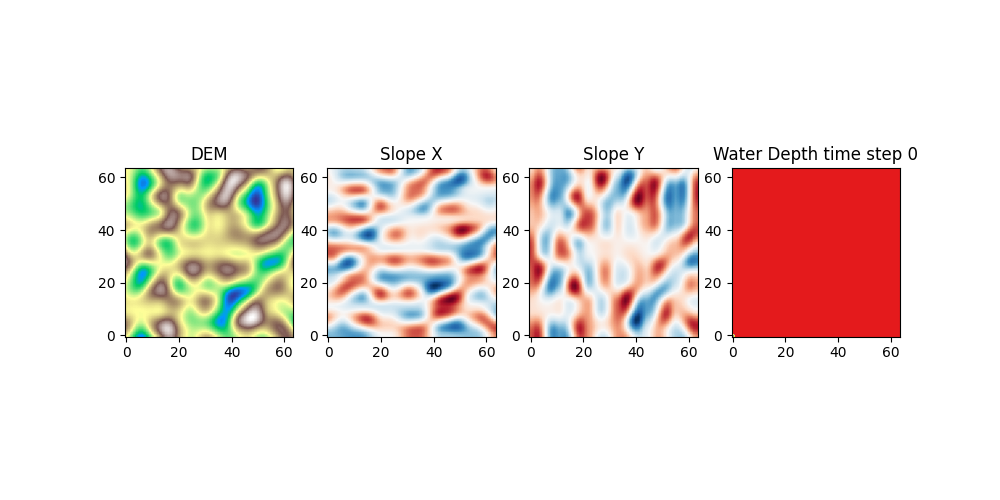

In [11]:
# From FAT application
fig, axs = plt.subplots(1, 4, figsize=(10, 5))

# specify which entry of the dataset to plot
numb = 0

axs[0].imshow(train_dataset[numb][0][0][0].cpu(), cmap='terrain', origin='lower')
axs[0].set_title('DEM')

axs[1].imshow(train_dataset[numb][0][0][1].cpu(), cmap='RdBu', origin='lower')
axs[1].set_title('Slope X')

axs[2].imshow(train_dataset[numb][0][0][2].cpu(), cmap='RdBu', origin='lower')
axs[2].set_title('Slope Y')

axs[3].imshow(train_dataset[numb][0][0][3].cpu(), cmap='Set1', origin='lower')
axs[3].set_title('Water Depth time step 0')

In [12]:
# Normalize the inputs and outputs using training dataset
scaler_x, scaler_y = scaler(train_dataset)

normalized_train_dataset = normalize_dataset(train_dataset, scaler_x, scaler_y)
normalized_test_dataset = normalize_dataset(test_dataset1, scaler_x, scaler_y)

In [13]:
# Split dataset into train and validation
train_percnt = 0.8
train_size = int(train_percnt * len(train_dataset))
val_size = len(train_dataset) - train_size
train_set, val_set = random_split(normalized_train_dataset, [train_size, val_size])

In [24]:
# Model, check, not sure num_layers is the expected amount of outputs
model = ConvLSTM(input_dim = train_set[0][0].shape[1], hidden_dim = 2, kernel_size = (9, 9), num_layers = 48,
         batch_first=True, bias=False, return_all_layers = True).to(device)
# return all layers has to be true to obtain all the outputs I think
# num_layers refers to the number of cells and thus outputs
# I think hidden_dim has to be 2, in order to get 2 outputs?

In [25]:
model

ConvLSTM(
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(6, 8, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4), bias=False)
    )
    (1): ConvLSTMCell(
      (conv): Conv2d(4, 8, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4), bias=False)
    )
    (2): ConvLSTMCell(
      (conv): Conv2d(4, 8, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4), bias=False)
    )
    (3): ConvLSTMCell(
      (conv): Conv2d(4, 8, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4), bias=False)
    )
    (4): ConvLSTMCell(
      (conv): Conv2d(4, 8, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4), bias=False)
    )
    (5): ConvLSTMCell(
      (conv): Conv2d(4, 8, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4), bias=False)
    )
    (6): ConvLSTMCell(
      (conv): Conv2d(4, 8, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4), bias=False)
    )
    (7): ConvLSTMCell(
      (conv): Conv2d(4, 8, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4), bias=False)
    )
    (8): Co

In [26]:
def train_epoch(model, loader, optimizer, device):
    model.to(device)
    model.train() # specifies that the model is in training mode

    losses = []

    for batch in loader:
        x = batch[0].to(device)
        y = batch[1].to(device)

        # Model prediction
        preds, _ = model(x)
        list_preds = torch.cat(preds, dim=1) # concat over the dimension 1 (time steps)
        # MSE loss function
        loss = nn.MSELoss()(list_preds, y)
        
        losses.append(loss.cpu().detach())
        
        # Backpropagate and update weights
        loss.backward()   # compute the gradients using backpropagation
        optimizer.step()  # update the weights with the optimizer
        optimizer.zero_grad(set_to_none=True)   # reset the computed gradients

    losses = np.array(losses).mean()

    return losses

In [27]:
def evaluation(model, loader, device):
    model.to(device)
    model.eval() # specifies that the model is in evaluation mode 

    losses = []

    for batch in loader:
        x = batch[0].to(device)
        y = batch[1].to(device)

        # Model prediction
        preds, _ = model(x)
        list_preds = torch.cat(preds, dim=1)

        # MSE loss function
        loss = nn.MSELoss()(list_preds, y)
        
        losses.append(loss.cpu().detach())
        
        # Backpropagate and update weights
        loss.backward()   # compute the gradients using backpropagation

    losses = np.array(losses).mean()

    return losses

In [29]:
# Set training parameters
learning_rate = 0.001
batch_size = 8 # Only have 64 and 16 samples for training and validation, I think should be kept small, having issues where this only works if set to 1
num_epochs = 3000

# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Create the training and validation dataloaders to "feed" data to the model in batches
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [30]:
train_losses = []
val_losses = []

for epoch in range(1, num_epochs+1):
    # Model training
    train_loss = train_epoch(model, train_loader, optimizer, device=device)

    # Model validation
    val_loss = evaluation(model, val_loader, device=device)

    if epoch == 1:
        best_loss = val_loss
    
    if val_loss<=best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_epoch = epoch

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if epoch%100 == 0:
        print("epoch:",epoch, "\t training loss:", np.round(train_loss,4),
                            "\t validation loss:", np.round(val_loss,4))
        
model = copy.deepcopy(best_model)

epoch: 100 	 training loss: 0.0021 	 validation loss: 0.0022
epoch: 200 	 training loss: 0.002 	 validation loss: 0.0021
epoch: 300 	 training loss: 0.002 	 validation loss: 0.0021
epoch: 400 	 training loss: 0.002 	 validation loss: 0.0021
epoch: 500 	 training loss: 0.002 	 validation loss: 0.0021
epoch: 600 	 training loss: 0.0021 	 validation loss: 0.0021
epoch: 700 	 training loss: 0.002 	 validation loss: 0.0021
epoch: 800 	 training loss: 0.002 	 validation loss: 0.0021
epoch: 900 	 training loss: 0.002 	 validation loss: 0.0021
epoch: 1000 	 training loss: 0.002 	 validation loss: 0.0021
epoch: 1100 	 training loss: 0.0019 	 validation loss: 0.002
epoch: 1200 	 training loss: 0.0018 	 validation loss: 0.0019
epoch: 1300 	 training loss: 0.002 	 validation loss: 0.0021
epoch: 1400 	 training loss: 0.0016 	 validation loss: 0.0015
epoch: 1500 	 training loss: 0.0013 	 validation loss: 0.0012
epoch: 1600 	 training loss: 0.0012 	 validation loss: 0.0011
epoch: 1700 	 training loss

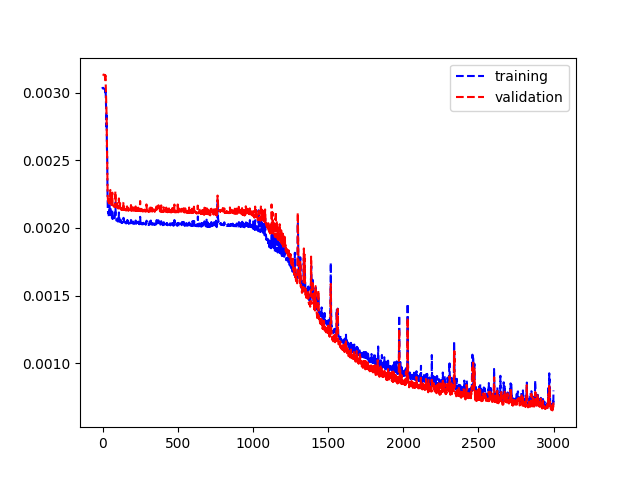

In [31]:
plt.figure() 
plt.plot(train_losses, color='blue', ls='--', label='training')
plt.plot(val_losses, color='red', ls='--', label='validation')
plt.legend()
plt.show()

In [32]:
sample_0, _ = model(train_set[0][0].unsqueeze(0).to(device)) # create a batch of 1?
prediction = torch.cat(sample_0, dim=1).detach()

In [33]:
prediction.shape

torch.Size([1, 48, 2, 64, 64])

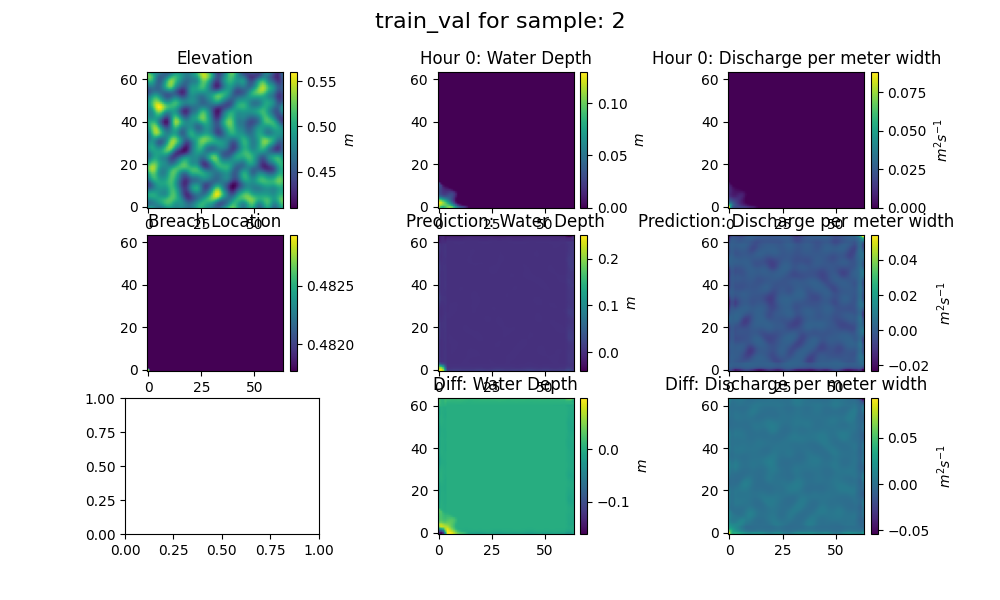

MovieWriter Pillow unavailable; using Pillow instead.


In [38]:
plot_animation(2, train_set, prediction.cpu(), train_val, True)